In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
from sklearn import linear_model
from sklearn.cluster import KMeans
#! pip install mlxtend
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

from sklearn.cluster import KMeans
import scipy.spatial as spatial
import random



In [ ]:
#Data source:https://www.kaggle.com/datasets/ihormuliar/starbucks-customer-data?select=profile.csv

# Data processing

In [ ]:
#data includes user id, event, offer identifier and time to use (describes events)
data = pd.read_csv("transcript.csv")
data = data.set_index('Unnamed: 0')

In [ ]:
def extract_offer_id(s):
    offer_id_regex = r"id':\s*'([a-zA-Z0-9]*)'"

    offer_id_result = re.search(offer_id_regex, s)

    if offer_id_result:
        return offer_id_result.group(1)


def extract_amount(s):
    amount_regex = r"unt':\s*([\.0-9]*)"

    amount_result = re.search(amount_regex, s)

    if amount_result:
        return amount_result.group(1)

def extract_reward(s):
    reward_regex = r"ard':\s*([\.0-9]*)"

    reward_result = re.search(reward_regex, s)

    if reward_result:
        return reward_result.group(1)

data['offer_id'] = data['value'].apply(lambda x : extract_offer_id(x))
data['amount'] = data['value'].apply(lambda x : extract_amount(x))
data['reward'] = data['value'].apply(lambda x : extract_reward(x))

del data['value']

In [ ]:
#portfolio (information about the offers)
portfolio = pd.read_csv("portfolio.csv")
portfolio = portfolio.drop('Unnamed: 0',axis=1).set_index('id')
del portfolio['reward'] #repeated in transcript

In [ ]:
#profiles (describe the customers)
profiles = pd.read_csv("profile.csv")
profiles = profiles.drop('Unnamed: 0',axis=1).set_index('id')
profiles['became_member_on'] = pd.to_datetime(profiles['became_member_on'],format='%Y%m%d')
#age 118 is repeating 2175 times and seems to be a mistake, we drop these customers
profiles = profiles[profiles['age']!=118]

In [ ]:
#merge all the tables to data for further analysis
df = pd.merge(data, portfolio, left_on='offer_id', right_index=True,how='left')
df = pd.merge(df, profiles, left_on='person', right_index=True,how='right')

In [ ]:
data_types_dict = {'reward':float,'amount':float}
df = df.astype(data_types_dict)
df[['reward','amount','difficulty','duration']] = df[['reward','amount','difficulty','duration']].fillna(0)

In [ ]:
df.head()

,person,event,time,offer_id,amount,reward,channels,difficulty,duration,offer_type,gender,age,became_member_on,income
Unnamed: 0,,,,,,,,,,,,,,
20282,0610b486422d4921ae7d2bf64640c50b,transaction,18,None,21.51,0.0,NaN,0.0,0.0,NaN,F,55,2017-07-15,112000.0
49501,0610b486422d4921ae7d2bf64640c50b,transaction,144,None,32.28,0.0,NaN,0.0,0.0,NaN,F,55,2017-07-15,112000.0
150597,0610b486422d4921ae7d2bf64640c50b,offer received,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,0.0,"['web', 'email', 'mobile']",5.0,7.0,bogo,F,55,2017-07-15,112000.0
201571,0610b486422d4921ae7d2bf64640c50b,offer received,504,3f207df678b143eea3cee63160fa8bed,0.00,0.0,"['web', 'email', 'mobile']",0.0,4.0,informational,F,55,2017-07-15,112000.0
227842,0610b486422d4921ae7d2bf64640c50b,transaction,528,None,23.22,0.0,NaN,0.0,0.0,NaN,F,55,2017-07-15,112000.0


# Data Presentation

In [ ]:
len(df)

272762

In [ ]:
f"Data describes {df['offer_id'].nunique()} offers in a period of {df['time'].max()/24} days. There are {len(profiles)} properly described users and {len(df[df['event']=='transaction'])} transactions not connected to offers"
#reward - value of the offer
#difficulty - how much money costomer has to spend to get the offer
#time - from beginning of the months, in hours
#duration - how long the offer is valid in days


'Data describes 10 offers in a period of 29.75 days. There are 14825 properly described users and 123957 transactions not connected to offers'

Text(0.5, 1.0, 'Time when offers were released to users')

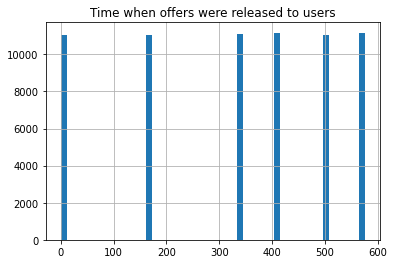

In [ ]:
df[df['event']=='offer received']['time'].hist(bins=50)
plt.title("Time when offers were released to users")

Text(0.5, 1.0, "Distribution of the offers' completion in time")

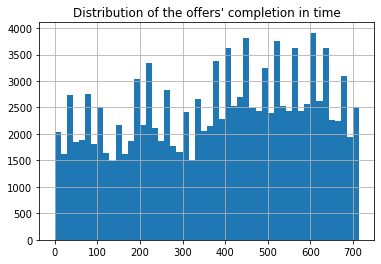

In [ ]:
#and when the offers were used
df[df['event']=='transaction']['time'].hist(bins=50)
plt.title("Distribution of the offers' completion in time")

In [ ]:
# def time_of_day(time_int):  <---- this function is not used as the realtime of day is not reported in the data
#     if time_int%24 < 6:
#         return 'night'
#     if time_int%24 <10:
#         return 'morning'
#     if time_int%24 <14:
#         return 'midday'
#     if time_int%24 <18:
#         return 'afternoon'
#     if time_int%24 <22:
#         return 'evening'
#     else:
#         return 'night'
#df['time of day'] = df['time'].apply(lambda x: time_of_day(x))

In [ ]:
# hour_of_day = df['time'].apply(lambda x: x%24)
# print(hour_of_day.unique())
# hour_of_day.hist()

## User characteristics

Median age: 55.0
41.0 66.0


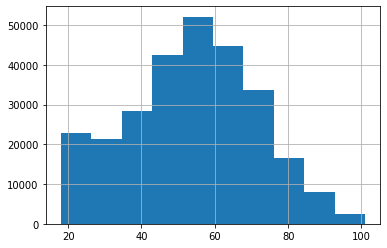

In [ ]:
df['age'].hist()
print("Median age: " + str(df['age'].median()))
print(str(df['age'].quantile(0.25)) + ' ' + str(df['age'].quantile(0.75)))

Median income: 62000.0
Mean income: 64337.00075523717
48000.0 78000.0


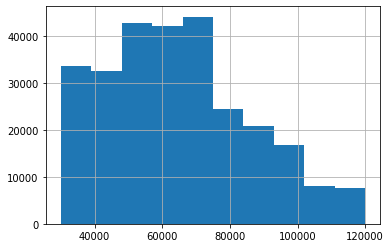

In [ ]:
df['income'].hist()
print("Median income: " + str(df['income'].median()))
print("Mean income: " + str(df['income'].mean()))
print(str(df['income'].quantile(0.25)) + ' ' + str(df['income'].quantile(0.75)))

In [ ]:
print('percent of purchases that come from completing offers:')
print(len(df[df['event'] == 'offer completed'])/(len(df[df['event'] == 'offer completed']) + len(df[df['event'] == 'transaction'])))
print('percent of revenue from offers')
print(np.sum(df[df['event'] == 'offer completed']['difficulty']) / (np.sum(df[df['event'] == 'offer completed']['difficulty']) + np.sum(df[df['event'] == 'transaction']['amount'])))

percent of purchases that come from completing offers:
0.20744112889303776
percent of revenue from offers
0.14833961946649044


In [ ]:
print('percent of male:')
print((profiles.groupby(by='gender').count().loc['M',:]/len(profiles))[0])

percent of male:
0.5722765598650927


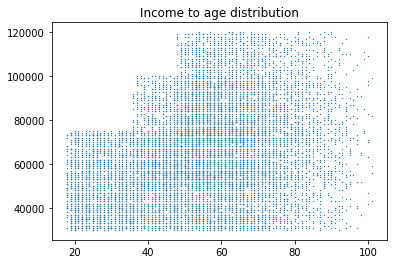

In [ ]:
plt.scatter(profiles['age'],profiles['income'],marker='x',s=0.1)
plt.title('Income to age distribution') ;

# Pre-processing

### Gather the statistics about offers in 'offers' dataframe

In [ ]:
offers = pd.DataFrame(index=portfolio.index)

offers['number of completions'] = df[df['event']=='offer completed'].groupby(by='offer_id').count()['event']
offers['number of times received'] = df[df['event']=='offer received'].groupby(by='offer_id').count()['event']
offers['rate(%)'] = offers['number of completions']/offers['number of times received']*100
time_diffs = df.pivot_table(columns='event',values='time',index=['person','offer_id']).dropna()['offer completed'] - df.pivot_table(columns='event',values='time',index=['person','offer_id']).dropna()['offer received']
time_diffs = time_diffs[time_diffs >= 0]
offers['average time to completion'] =  time_diffs.reset_index().groupby(by='offer_id').mean()[0]

offers = pd.merge(offers, portfolio, left_index=True, right_index=True, how='outer')

In [ ]:
offers.head()

,number of completions,number of times received,rate(%),average time to completion,channels,difficulty,duration,offer_type
id,,,,,,,,
ae264e3637204a6fb9bb56bc8210ddfd,3657.0,6683,54.720934,59.885345,"['email', 'mobile', 'social']",10,7,bogo
4d5c57ea9a6940dd891ad53e9dbe8da0,3310.0,6593,50.204763,50.185599,"['web', 'email', 'mobile', 'social']",10,5,bogo
3f207df678b143eea3cee63160fa8bed,NaN,6657,NaN,NaN,"['web', 'email', 'mobile']",0,4,informational
9b98b8c7a33c4b65b9aebfe6a799e6d9,4188.0,6685,62.647719,62.560652,"['web', 'email', 'mobile']",5,7,bogo
0b1e1539f2cc45b7b9fa7c272da2e1d7,3386.0,6726,50.341957,96.467468,"['web', 'email']",20,10,discount


### Gather information about user characteristics and behaviour in 'user_offers' dataframe

In [ ]:
received_offers = df[df['event']=='offer received']
count_r = received_offers[['person','event']].groupby('person').count().fillna(0)

completed_offers = df[df['event']=='offer completed']
count_c = completed_offers[['person','event']].groupby('person').count().fillna(0)

user_offers = profiles.copy()

#count_offers = pd.merge(count_r, count_c, left_index=True, right_index=True, how = 'outer') #merge
user_offers['offer received'] = count_r
user_offers['offer completed'] = count_c
user_offers['rate(%)'] = user_offers['offer completed'] / user_offers['offer received']


#user_offers = pd.merge(profiles, count_offers, left_index=True, right_index=True, how = 'outer') #merge
user_offers['transactions sum'] = df[df['event']=='transaction'][['person','amount']].groupby('person').sum().fillna(0)
user_offers['profit from offers sum'] = df[df['event']=='offer completed'][['person','difficulty']].groupby('person').sum().fillna(0)['difficulty'] - df[df['event']=='offer completed'][['person','reward']].groupby('person').sum().fillna(0)['reward']

completion_pivot = df[['person','event','time','offer_id']].pivot_table(columns=['event'],values='time',index=['person','offer_id'])
user_offers['time to offer completion avg'] = (completion_pivot['offer completed'] - completion_pivot['offer received']).dropna().reset_index().groupby('person').mean()
user_offers['revenue from customer sum'] = user_offers['profit from offers sum'] + user_offers['transactions sum']
user_offers = user_offers.dropna()

In [ ]:
# The transactions the users make (event == transaction)
transaction = df[['person', 'event']]
transaction = transaction[transaction.event == 'transaction']
transaction = transaction['person'].value_counts() #counting the number of transactions for each user

user_offers['n_transactions'] = transaction.fillna(0) #complete the missing values with 0

In [ ]:
user_offers.head()

,gender,age,became_member_on,income,offer received,offer completed,rate(%),transactions sum,profit from offers sum,time to offer completion avg,revenue from customer sum,n_transactions
id,,,,,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,F,55,2017-07-15,112000.0,2.0,1.0,0.500000,77.01,0.0,120.0,77.01,3
78afa995795e4d85b5d9ceeca43f5fef,F,75,2017-05-09,100000.0,4.0,3.0,0.750000,159.27,0.0,80.0,159.27,7
e2127556f4f64592b11af22de27a7932,M,68,2018-04-26,70000.0,4.0,2.0,0.500000,57.73,8.0,66.0,65.73,3
389bc3fa690240e798340f5a15918d5c,M,65,2018-02-09,53000.0,6.0,5.0,0.833333,36.43,16.0,118.5,52.43,3
2eeac8d8feae4a8cad5a6af0499a211d,M,58,2017-11-11,51000.0,3.0,1.0,0.333333,15.62,8.0,120.0,23.62,4


# Analysis

Revenue per gender

In [ ]:
revenues_per_gender = user_offers[['revenue from customer sum','gender']].groupby('gender').sum()
user_count_per_gender = user_offers[['revenue from customer sum','gender']].groupby('gender').count()
revenues_per_gender / user_count_per_gender

,revenue from customer sum
gender,
F,168.989559
M,136.622216
O,156.290670


Avergage offers and transactions numbers per customer

2.7068246287335223
9.21858835307859


<AxesSubplot:>

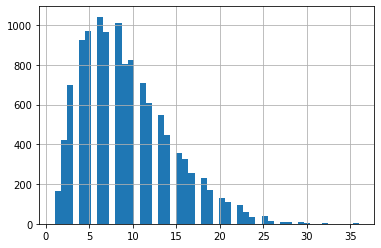

In [ ]:
print(user_offers['offer completed'].mean())
print(user_offers['n_transactions'].mean())
user_offers['n_transactions'].hist(bins=50)

## Linear Regression to predict revenue coming from a customer

Let's try to fit a linear regression model to the data, where x is the users' characteristics and y is 1) sum of transactions they made 2) the amount they spent on offers 3) total revenue connected to the cutomer

Text(0, 0.5, "Revenue from the offers' completion")

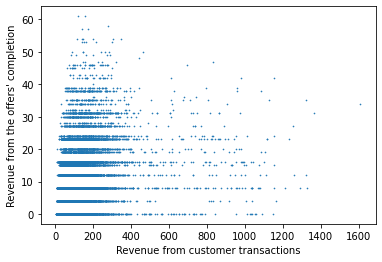

In [ ]:
xy = user_offers.dropna()
x = pd.get_dummies(xy[['gender', 'age', 'income', 'offer received']], columns = ['gender']) #, 'time to offer completion avg'
y = xy['revenue from customer sum']
#y = xy['transactions sum']
#y = xy['profit from offers sum']
plt.scatter(xy['transactions sum'],xy['profit from offers sum'],s=0.4)
plt.xlabel('Revenue from customer transactions')
plt.ylabel("Revenue from the offers' completion")

In [ ]:
regr=linear_model.LinearRegression(fit_intercept=True)
regr.fit(x, y)

#print coefficients with names
for cname, val in zip(x.columns, regr.coef_.tolist()):
    print(f"{cname} =  {val:.3f}")

#calculate error
error=regr.predict(x) - y
print("Expected value of the error (or Average error, AE): %.2f" % np.mean(error))

age =  -0.047
income =  0.002
offer received =  13.318
gender_F =  5.168
gender_M =  -13.555
gender_O =  8.387
Expected value of the error (or Average error, AE): 0.00


In [ ]:
print(f"Mean absolute error: {np.mean(np.abs(error))}")
print(f"Mean y value: {np.mean(y)}")

Mean absolute error: 80.51884221699224
Mean y value: 151.47395961955615


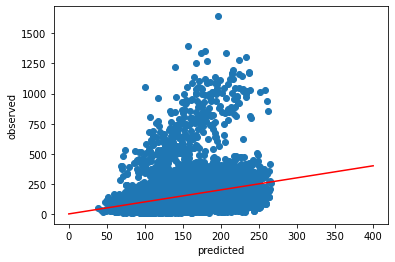

In [ ]:
# 45 degree plot
plt.scatter(regr.predict(x),y)
plt.xlabel("predicted")
plt.ylabel("observed")
plt.plot([0, 400], [0, 400], color="red")

Analysis of the errors and 45 degree plots suggests there is no linear relationship between the customer characteristics and their revenue for the company (neither when it is divided into offers and trnsactions revenue)

## Age groups analysis

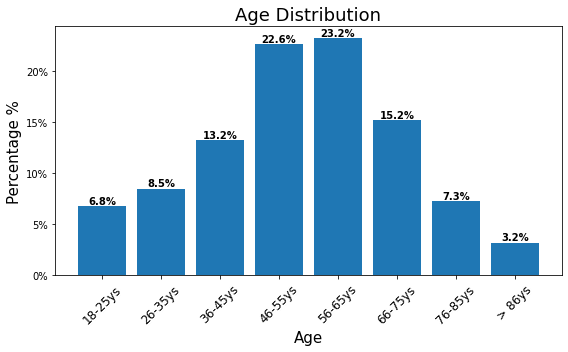

In [ ]:
# Create a new column `age_group`
user_offers['age_group'] = pd.cut(user_offers['age'],
      bins = [user_offers['age'].min()-1, 26, 36, 46, 56, 66, 76, 86, user_offers['age'].max()],
      labels = ['18-25ys', '26-35ys', '36-45ys', '46-55ys', '56-65ys', '66-75ys', '76-85ys', '> 86ys'])

# Visualize customers by age groups
age_group_percentage = (user_offers.value_counts('age_group').sort_index() / user_offers.shape[0] * 100).round(1)
plt.figure(figsize = (8, 5))
yticks = np.arange(0,25,5)
yticklabels = [str(y) + '%' for y in yticks]
plt.yticks(yticks, labels = yticklabels)
plt.xticks(rotation = 45, fontsize = 12)
plt.xlabel('Age', fontsize = 15)
plt.ylabel('Percentage %', fontsize = 15)
plt.title('Age Distribution', fontsize = 18)

bar_plot = plt.bar(x = age_group_percentage.index.values, height = age_group_percentage)
for i,bar in enumerate(bar_plot.patches):
    x, y = bar.get_xy()
    plt.text(x+bar.get_width()/2, y+bar.get_height()+0.2,
            str(age_group_percentage[i]) + '%',
            ha = 'center', weight = 'bold')

plt.tight_layout()
plt.show()

In [ ]:
user_offers['age'].mean()

55.23660937760721

## Grouping customers based on earned revenues

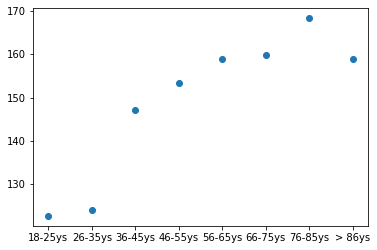

In [ ]:
revenue_sum = user_offers.groupby('age_group', as_index=False)['revenue from customer sum'].mean()
revenue_sum.rename(columns = {'revenue from customer sum':'revenue'}, inplace = True)
plt.scatter(x=revenue_sum["age_group"], y=revenue_sum["revenue"])

<AxesSubplot:xlabel='age_group'>

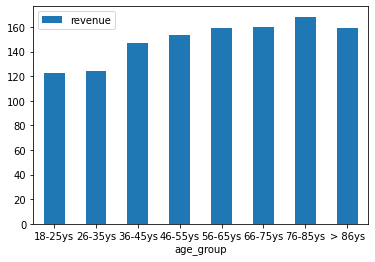

In [ ]:
revenue_sum.plot.bar(x='age_group', y='revenue', rot=0)

## Finding most completed offer

In [ ]:
(offers['number of completions']/offers['number of times received']).sort_values(ascending=False).head(10)

id
fafdcd668e3743c1bb461111dcafc2a4    0.752105
2298d6c36e964ae4a3e7e9706d1fb8c2    0.734185
9b98b8c7a33c4b65b9aebfe6a799e6d9    0.626477
f19421c1d4aa40978ebb69ca19b0e20d    0.623936
2906b810c7d4411798c6938adc9daaa5    0.589805
ae264e3637204a6fb9bb56bc8210ddfd    0.547209
0b1e1539f2cc45b7b9fa7c272da2e1d7    0.503420
4d5c57ea9a6940dd891ad53e9dbe8da0    0.502048
3f207df678b143eea3cee63160fa8bed         NaN
5a8bc65990b245e5a138643cd4eb9837         NaN
dtype: float64

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'ae264e3637204a6fb9bb56bc8210ddfd'),
  Text(1, 0, '4d5c57ea9a6940dd891ad53e9dbe8da0'),
  Text(2, 0, '3f207df678b143eea3cee63160fa8bed'),
  Text(3, 0, '9b98b8c7a33c4b65b9aebfe6a799e6d9'),
  Text(4, 0, '0b1e1539f2cc45b7b9fa7c272da2e1d7'),
  Text(5, 0, '2298d6c36e964ae4a3e7e9706d1fb8c2'),
  Text(6, 0, 'fafdcd668e3743c1bb461111dcafc2a4'),
  Text(7, 0, '5a8bc65990b245e5a138643cd4eb9837'),
  Text(8, 0, 'f19421c1d4aa40978ebb69ca19b0e20d'),
  Text(9, 0, '2906b810c7d4411798c6938adc9daaa5')])

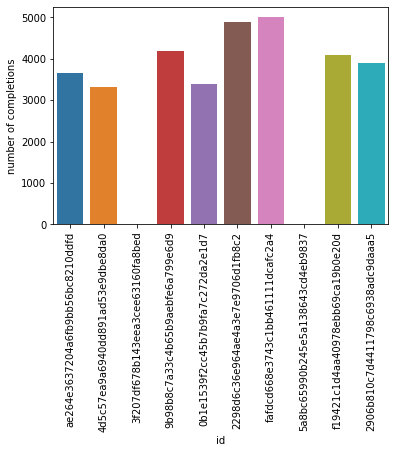

In [ ]:
sns.barplot(data = offers.reset_index(), x='id',y='number of completions')
plt.xticks(rotation = 'vertical')

### Are customers who complete the most offers the most profitable ones for the company?

In [ ]:
np.corrcoef(user_offers['transactions sum'], user_offers['offer completed'])

array([[1.        , 0.43403905],
       [0.43403905, 1.        ]])

### Do customers who receive less offers are less profitable?

In [ ]:

np.corrcoef(user_offers['transactions sum'], user_offers['offer received'])

array([[1.       , 0.0779909],
       [0.0779909, 1.       ]])

# Clustering and frequent items analysis

3 different tables to do clustering on:
- person characteristics: use "users"
- number of transactions: "user_trans"
- offers: "user_offers"

### K-means

First trial with the user data: age vs n_transactions

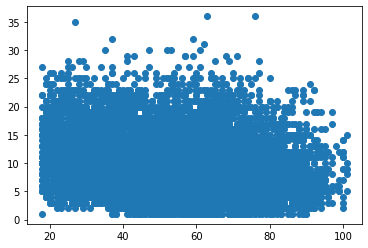

In [ ]:
x = user_offers[['age','n_transactions']].dropna()['age']
y = user_offers[['age','n_transactions']].dropna()['n_transactions']

plt.scatter(x,y)
plt.show()


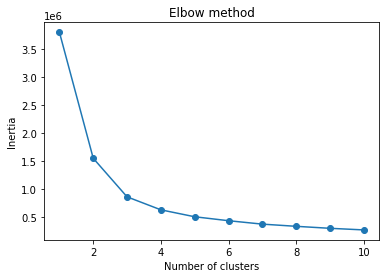

In [ ]:
#USE ELBOW METHOD TO DETERMINE NUMBER OF CLUSTERS IN A DATA SET
xy = list(zip(x,y))
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(xy)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11),inertias,marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()


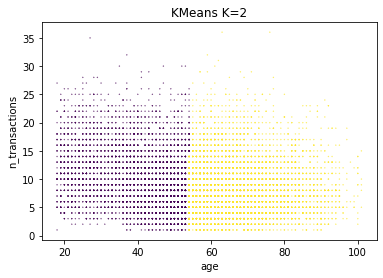

In [ ]:
#THE PREVIOUS METHOD SHOWS THE APPROPRIATE NUMBER OF CLUSTERS.

kmeans = KMeans(n_clusters=2)
kmeans.fit(xy)
plt.scatter(x,y, c=kmeans.labels_,s=0.1)
plt.title('KMeans K=2')
plt.xlabel('age')
plt.ylabel('n_transactions')
plt.show()

Second trial with the age and income

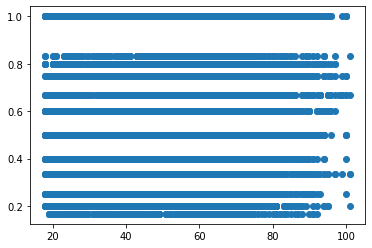

In [ ]:
x = user_offers['age']
y = user_offers['rate(%)']

plt.scatter(x,y)
plt.show()

age and time to offer completion

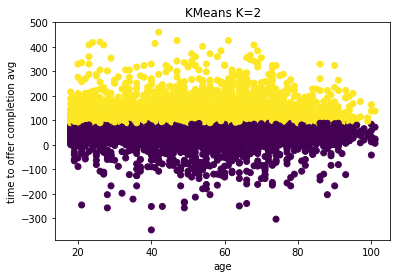

In [ ]:
x = user_offers['age']
y = user_offers['time to offer completion avg']
xy = list(zip(x,y))

kmeans_time = KMeans(n_clusters=2)
kmeans_time.fit(xy)
plt.scatter(x,y, c=kmeans_time.labels_)
plt.title('KMeans K=2')
plt.xlabel('age')
plt.ylabel('time to offer completion avg')
plt.show()

Income and age versus profit from customer

In [ ]:
x = user_offers[['income','age']]
y = user_offers['profit from offers sum'] # + user_offers['transactions sum']
xy = user_offers[['income','age','profit from offers sum']].to_numpy()
kmeans2 = KMeans(n_clusters=2)
kmeans2.fit(xy)

KMeans(n_clusters=2)

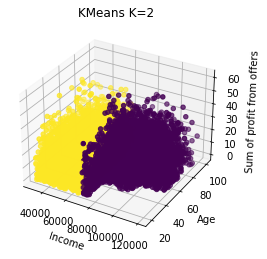

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(x['income'],x['age'],y, c=kmeans2.labels_)

plt.title('KMeans K=2')
ax.set_xlabel('Income')
ax.set_ylabel('Age')
ax.set_zlabel('Sum of profit from offers')
plt.show()

### DBscan

#### Implementation

In [ ]:
def get_neighbors(eps, d, idx, point_tree):
    dimensions = list(d.iloc[idx])

    neighbors = point_tree.query_ball_point(dimensions, eps)
    neighbors.remove(idx)

    return neighbors

In [ ]:
def dbscan(eps, min_samples, d: pd.DataFrame):
    # List to keep track points unvisited so far
    unvisited = [i for i in range(len(d))]
    # All points start as noise
    dbscan_labels = [-1 for _ in range(len(unvisited))]

    # K-Dimensional tree of points
    point_tree = spatial.cKDTree(d)
    # List of neighbors per point withing given epsilon
    neighbors = []
    # List of core points
    cores = []
    # Filling in lists of neighbors and core points
    for i in range(len(unvisited)):
        current_neighbors = get_neighbors(eps, d, i, point_tree)
        neighbors.append(current_neighbors)
        if len(current_neighbors) > min_samples:
            cores.append(i)

    cluster_number = 1
    frontier = set()

    while cores:
        # Appending an index of a random unvisited core point to the frontier to begin with
        frontier.add(random.choice(cores))

        while frontier:
            curr_point_idx = frontier.pop()
            unvisited.remove(curr_point_idx)
            dbscan_labels[curr_point_idx] = cluster_number

            if curr_point_idx in cores:
                cores.remove(curr_point_idx)
                frontier.update([n for n in neighbors[curr_point_idx] if n in unvisited])

            # if it's not core then we continue but without expanding frontier, as it has to be a border, no option that it's noise!
        cluster_number += 1

    return dbscan_labels

#### Usage

##### Age vs Number of transactions

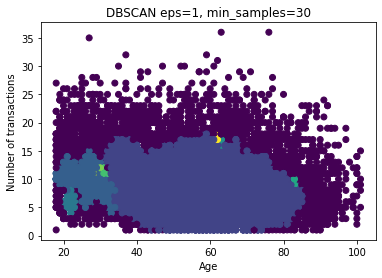

In [ ]:
labels = dbscan(1, 30, user_offers[['age', 'n_transactions']])

plt.scatter(x=user_offers['age'], y=user_offers['n_transactions'], c=labels)
plt.title('DBSCAN eps=1, min_samples=30')
plt.xlabel('Age')
plt.ylabel('Number of transactions')
plt.show()

##### Age vs Time to offer completion

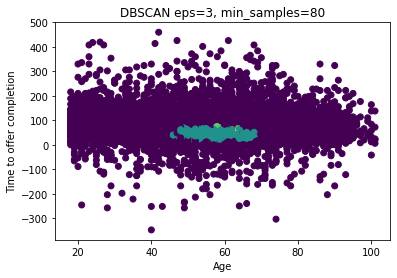

In [ ]:
labels = dbscan(3,80, user_offers[['age', 'time to offer completion avg']])

plt.scatter(x=user_offers['age'], y=user_offers['time to offer completion avg'], c=labels)
plt.title('DBSCAN eps=3, min_samples=80')
plt.xlabel('Age')
plt.ylabel('Time to offer completion')
plt.show()

##### Age vs Number of transactions vs Sum of profit from offers

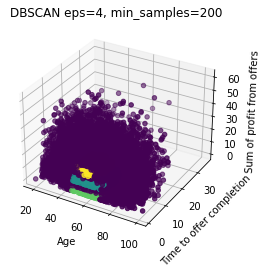

In [ ]:
labels = dbscan(4, 200, user_offers[['age', 'n_transactions', 'profit from offers sum']])

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(user_offers['age'], user_offers['n_transactions'], user_offers['profit from offers sum'], c=labels)
plt.title('DBSCAN eps=4, min_samples=200')
ax.set_xlabel('Age')
ax.set_ylabel('Time to offer completion')
ax.set_zlabel('Sum of profit from offers')
plt.show()

### Frequent items - Apriori algorithm

http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/

In [ ]:
data_fr_items = data[data['event']=='offer completed'][['person','offer_id']].groupby(['person'], as_index=False).agg({'offer_id': ','.join})
fr_items = data_fr_items.iloc[:,1].tolist()

In [ ]:
list_offer_id = [item.split(',') for item in fr_items]
te = TransactionEncoder()
te_ary = te.fit(list_offer_id).transform(list_offer_id)
items = pd.DataFrame(te_ary, columns=te.columns_)
items.head()

,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
0,False,False,True,False,False,False,True,True
1,True,True,False,False,True,False,False,False
2,False,False,False,True,False,False,False,True
3,False,True,False,False,True,False,True,False
4,True,False,False,False,False,False,False,True


In [ ]:
#create a disctionary with keys 1 - 8 and values items.columns
dict_items = dict(zip(items.columns,range(1,9)))

In [ ]:
table = items.head(5)
#pd.DataFrame(table).to_latex(index=False)

In [ ]:
supports = apriori(items, min_support=0.01, use_colnames=True)

In [ ]:
t = supports.sort_values(by='support', ascending=False).head(15)

In [ ]:
#pd.DataFrame(t).to_latex(index=False)

## Frequent Items - Frequent Pattern (FP) Growth Algorithm

In [ ]:
data_fr_items2 = df[df['event']=='offer completed'][['person','offer_id']].groupby(['person'], as_index=False).agg({'offer_id': ','.join})
fr_items2 = data_fr_items2.iloc[:,1].tolist()

In [ ]:
list_offerid = [item.split(',') for item in fr_items2]

# instantiating a transaction encoder
fr_trasactionencoder = TransactionEncoder()

# fitting the transaction encoder using the list of transaction tuples
fr_trasactionencoder.fit(list_offerid)

# transforming the list of transaction tuples into an array of encoded transactions
fr_encodedtransactions = fr_trasactionencoder.transform(list_offerid)

# converting the array of encoded transactions into a dataframe
fr_encodedtransactions_df = pd.DataFrame(fr_encodedtransactions, columns=fr_trasactionencoder.columns_)
fr_encodedtransactions_df

,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
0,False,False,True,False,False,False,True,True
1,True,True,False,False,True,False,False,False
2,False,False,False,True,False,False,False,True
3,False,True,False,False,True,False,True,False
4,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...
11981,False,False,False,True,False,True,True,True
11982,False,False,True,False,True,False,False,True
11983,False,False,False,False,True,False,False,True
11984,False,False,False,False,True,False,True,False


In [ ]:
# our min support is 3, but it has to be expressed as a percentage for mlxtend
min_support = 3/len(list_offerid)

# computing the frequent itemsets using fpgriowth from mlxtend
from mlxtend.frequent_patterns.fpgrowth import fpgrowth
fpFrequent_itemsets = fpgrowth(fr_encodedtransactions_df, min_support=min_support, use_colnames = True)

# printing the frequent itemsets
fpFrequent_itemsets

,support,itemsets
0,0.354413,(fafdcd668e3743c1bb461111dcafc2a4)
1,0.297180,(f19421c1d4aa40978ebb69ca19b0e20d)
2,0.282246,(2906b810c7d4411798c6938adc9daaa5)
3,0.347656,(2298d6c36e964ae4a3e7e9706d1fb8c2)
4,0.302603,(9b98b8c7a33c4b65b9aebfe6a799e6d9)
...,...,...
212,0.019272,"(2298d6c36e964ae4a3e7e9706d1fb8c2, 9b98b8c7a33..."
213,0.003921,"(ae264e3637204a6fb9bb56bc8210ddfd, 9b98b8c7a33..."
214,0.003504,"(2298d6c36e964ae4a3e7e9706d1fb8c2, 9b98b8c7a33..."
215,0.000584,"(2298d6c36e964ae4a3e7e9706d1fb8c2, ae264e36372..."


In [ ]:
# computing and printing the association rules
association_rules(fpFrequent_itemsets, metric="confidence", min_threshold=0.3)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(2906b810c7d4411798c6938adc9daaa5),(fafdcd668e3743c1bb461111dcafc2a4),0.282246,0.354413,0.087686,0.310671,0.876578,-0.012346,0.936543
1,(0b1e1539f2cc45b7b9fa7c272da2e1d7),(2298d6c36e964ae4a3e7e9706d1fb8c2),0.245620,0.347656,0.076339,0.310802,0.893993,-0.009052,0.946526
2,(0b1e1539f2cc45b7b9fa7c272da2e1d7),(fafdcd668e3743c1bb461111dcafc2a4),0.245620,0.354413,0.078425,0.319293,0.900907,-0.008626,0.948407
3,(4d5c57ea9a6940dd891ad53e9dbe8da0),(fafdcd668e3743c1bb461111dcafc2a4),0.239029,0.354413,0.073085,0.305759,0.862719,-0.011630,0.929917
4,(4d5c57ea9a6940dd891ad53e9dbe8da0),(2298d6c36e964ae4a3e7e9706d1fb8c2),0.239029,0.347656,0.072835,0.304712,0.876477,-0.010265,0.938236
5,(ae264e3637204a6fb9bb56bc8210ddfd),(fafdcd668e3743c1bb461111dcafc2a4),0.262473,0.354413,0.079927,0.304514,0.859205,-0.013097,0.928252
